In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense , ELU, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from keras.regularizers import l1, l2
from sklearn.metrics import mean_squared_error as mse
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x = []
y_mean = []
y_std = []
x = np.array(x)
y_mean = np.array(y_mean)
y_std = np.array(y_std)

In [ ]:
data_path = "./drive/MyDrive/Parameter_estimation/normal_distribution/data.npz"
# Function to load data from file
def load_data(data_path):
    with np.load(data_path) as data:
        x_train = data['x_train']
        x_test = data['x_test']
        y_train_mean = data['y_train_mean']
        y_train_std = data['y_train_std']
        y_test_mean = data['y_test_mean']
        y_test_std = data['y_test_std']
    return x_train, x_test, y_train_mean, y_train_std, y_test_mean, y_test_std

# Load the data
x_train, x_test, y_train_mean, y_train_std, y_test_mean, y_test_std = load_data(data_path)
print("Training and test data loaded from file")

Training and test data loaded from file


In [ ]:
input_layer = Input(shape=(101,))

# Common hidden layers
hidden1 = Dense(64, activation='linear', kernel_regularizer=l1(0.01))(input_layer)
hidden2 = Dense(32, activation='linear', kernel_regularizer=l2(0.01))(hidden1)

#branching

mean_hidden3 = Dense(32, kernel_regularizer=l1(0.01))(hidden2)
mean_hidden3 = LeakyReLU()(mean_hidden3)

mean_hidden4 = Dense(16, kernel_regularizer=l2(0.01))(mean_hidden3)
mean_hidden4 = LeakyReLU()(mean_hidden4)

mean_output = Dense(1, activation='linear', kernel_regularizer=l2(0.01), name='mean_output')(mean_hidden4)

std_hidden5 = Dense(32, kernel_regularizer=l1(0.01))(hidden2)
std_hidden5 = Lambda(lambda x: tf.square(x))(std_hidden5)
std_hidden6 = Dense(16, kernel_regularizer=l2(0.01))(std_hidden5)
std_hidden6= Lambda(lambda x: tf.square(x))(std_hidden6)
std_output = Dense(1, activation='linear', kernel_regularizer=l1(0.01), name='std_output')(std_hidden6)

model = Model(inputs=input_layer, outputs=[mean_output, std_output])

# Compile the model with separate losses for each output
model.compile(
    optimizer='adam',
    loss={'mean_output': 'mean_squared_error', 'std_output': 'mean_squared_error'},
    metrics={'mean_output': ['mean_squared_error'], 'std_output': ['mean_squared_error']}
)

checkpoint_path = "./drive/MyDrive/Parameter_estimation/normal_distribution/model_checkpoint1.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'
)

# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)



In [ ]:
model.fit(
    x_train, {'mean_output': y_train_mean, 'std_output': y_train_std},
    validation_data=(x_test, {'mean_output': y_test_mean, 'std_output': y_test_std}),
    epochs=1000, batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/1000
125000/125000 [==============================] - 451s 4ms/step - loss: 9288572.0000 - mean_output_loss: 0.9420 - std_output_loss: 9288569.0000 - mean_output_mean_squared_error: 0.9420 - std_output_mean_squared_error: 9288569.0000 - val_loss: 20.1998 - val_mean_output_loss: 0.9051 - val_std_output_loss: 12.2189 - val_mean_output_mean_squared_error: 0.9051 - val_std_output_mean_squared_error: 12.2189
Epoch 2/1000
125000/125000 [==============================] - 459s 4ms/step - loss: 3.4846 - mean_output_loss: 0.8154 - std_output_loss: 1.1722 - mean_output_mean_squared_error: 0.8154 - std_output_mean_squared_error: 1.1722 - val_loss: 1.4455 - val_mean_output_loss: 0.7804 - val_std_output_loss: 0.4058 - val_mean_output_mean_squared_error: 0.7804 - val_std_output_mean_squared_error: 0.4058
Epoch 3/1000
125000/125000 [==============================] - 498s 4ms/step - loss: 1.4331 - mean_output_loss: 0.7773 - std_output_loss: 0.3977 - mean_output_mean_squared_error: 0.7773 - std_

In [ ]:
checkpoint_path = "./drive/MyDrive/Parameter_estimation/normal_distribution/model_checkpoint1.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'
)


In [ ]:

if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print(f"Loaded weights from {checkpoint_path}")

Loaded weights from ./drive/MyDrive/Parameter_estimation/normal_distribution/model_checkpoint1.h5


In [ ]:
np.random.seed(65)

num_distributions = 20
mean = 5
std = 5
n_values = np.arange(10,100,1)
mle_means = []
mle_stds = []
model_means = []
model_stds = []
true_means = []
true_stds = []
mse_mean_model = []
mse_std_model = []
mse_mean_mle = []
mse_std_mle = []
for num_samples in n_values:
    x = []
    y_mean = []
    y_std = []
    for i in range(100):
        samples = np.random.normal(mean, std, num_samples)
        samples = np.sort(samples)
        final_samples = np.insert(samples, 0, num_samples)
        x.append(final_samples)
        y_mean.append([mean])
        y_std.append([std])

    max_length = 101
    x = pad_sequences(x, maxlen=max_length, dtype='float32', padding='post', truncating='post')

    x = np.array(x)
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)

    predictions = model.predict(x)
    predicted_means = (predictions[0])
    predicted_stds = (predictions[1])


    mle_means_batch = []
    mle_stds_batch = []
    for sample in x:
        sample_size = int(sample[0])
        actual_samples = sample[1:sample_size + 1]
        mle_mean = np.mean(actual_samples)
        mle_std = np.std(actual_samples)
        mle_means_batch.append(mle_mean)
        mle_stds_batch.append(mle_std)

    mse_mean_model.append(mse(y_mean, predicted_means))
    mse_std_model.append(mse(y_std, predicted_stds))
    mse_mean_mle.append(mse(y_mean, mle_means_batch))
    mse_std_mle.append(mse(y_std, mle_stds_batch))

    mle_means.append(np.mean(mle_means_batch))
    mle_stds.append(np.mean(mle_stds_batch))
    model_means.append(np.mean(predicted_means))
    model_stds.append(np.mean(predicted_stds))
    true_means.append(np.mean(y_mean))
    true_stds.append(np.mean(y_std))

mse_mean_model = np.array((mse_mean_model))
mse_std_model = np.array(mse_std_model)
mse_mean_mle = np.array(mse_mean_mle)
mse_std_mle = np.array(mse_std_mle)

4/4 [==============================] - 0s 3ms/step


KeyboardInterrupt: 

In [ ]:
np.random.seed(65)

num_distributions = 20
mean = 5
std = 5
n_values = np.arange(10, 100, 1)
mle_means = []
mle_stds = []
model_means = []
model_stds = []
true_means = []
true_stds = []
mean_median = []
std_median = []
quantile_025_mean = []
quantile_975_mean = []
quantile_025_std = []
quantile_975_std = []
for num_samples in n_values:
    x = []
    y_mean = []
    y_std = []
    for i in range(100):
        samples = np.random.normal(mean, std, num_samples)
        samples = np.sort(samples)
        final_samples = np.insert(samples, 0, num_samples)
        x.append(final_samples)
        y_mean.append([mean])
        y_std.append([std])

    max_length = 101
    x = pad_sequences(x, maxlen=max_length, dtype='float32', padding='post', truncating='post')

    x = np.array(x)
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)

    predictions = model.predict(x)
    predicted_means = (predictions[0]).flatten()
    predicted_stds = (predictions[1]).flatten()

    quantile_025_mean.append(np.quantile(predicted_means, 0.025, axis=0))
    quantile_975_mean.append(np.quantile(predicted_means, 0.975, axis=0))
    quantile_025_std.append(np.quantile(predicted_stds, 0.025, axis=0))
    quantile_975_std.append(np.quantile(predicted_stds, 0.975, axis=0))
    mean_median.append(np.median(predicted_means, axis=0))
    std_median.append(np.median(predicted_stds, axis=0))


4/4 [==============================] - 0s 4ms/step


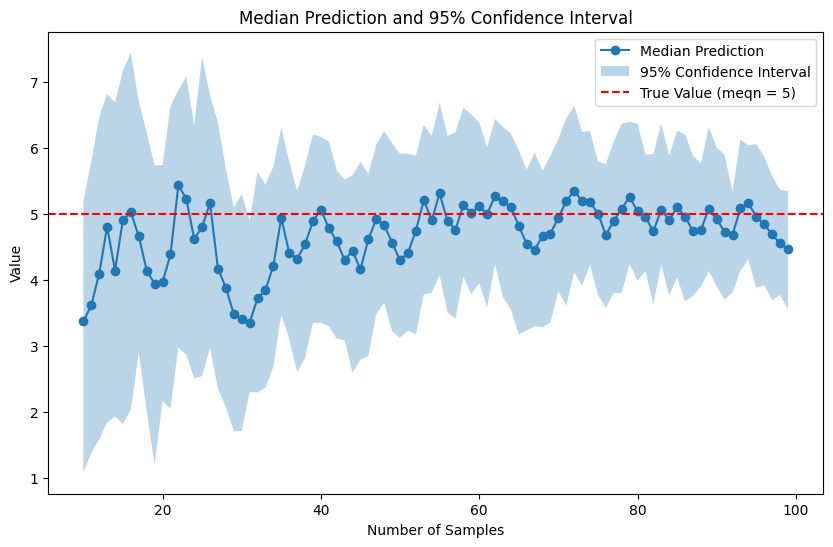

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
# Use n_values for both x and y dimensions for median_pred, quantile_025, and quantile_975
plt.plot(n_values, mean_median, label='Median Prediction', marker='o')
plt.fill_between(n_values, quantile_025_mean, quantile_975_mean, alpha=0.3, label='95% Confidence Interval')
plt.axhline(y=5, color='r', linestyle='--', label='True Value (meqn = 5)')
plt.ylabel('Value')
plt.xlabel('Number of Samples')
plt.title('Median Prediction and 95% Confidence Interval')
plt.legend()
plt.show()

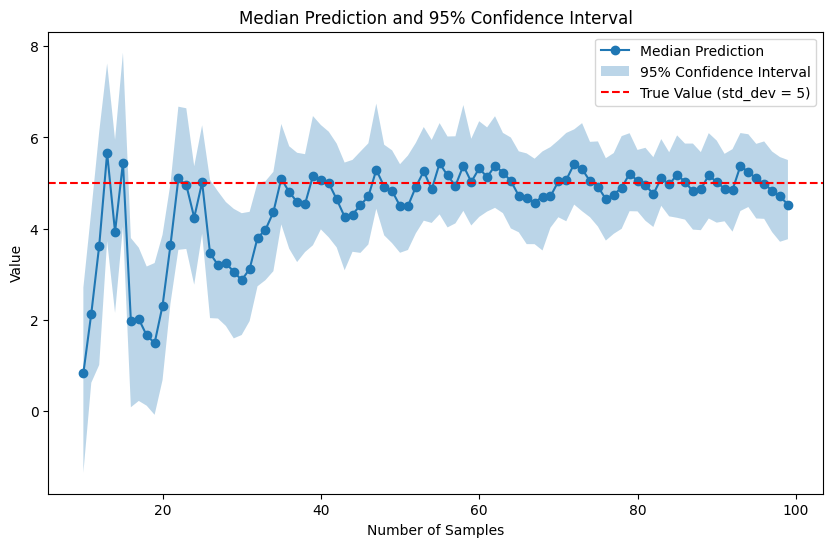

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
# Use n_values for both x and y dimensions for median_pred, quantile_025, and quantile_975
plt.plot(n_values, std_median, label='Median Prediction', marker='o')
plt.fill_between(n_values, quantile_025_std, quantile_975_std, alpha=0.3, label='95% Confidence Interval')
plt.axhline(y=5, color='r', linestyle='--', label='True Value (std_dev = 5)')
plt.ylabel('Value')
plt.xlabel('Number of Samples')
plt.title('Median Prediction and 95% Confidence Interval')
plt.legend()
plt.show()